# Data Science Life Cycle and Process

Step 1: Data Engineering 

- Get Data.ipynb
>
> This notebook is designed to be the start of the data ingestion pipeline 
> for getting the Raw Data from Sources, GTZAN and Spotify

Step 2: Exploratory Data Analysis 

- EDA.ipynb
>
> This notebook is designed to be the EDA for audio feature extraction using Librosa. 
> We will explore things like Mel-Frequency Cepstral Coefficients and Canstant-Q Transform and Chromagram with Pitch Classes

Step 3: Modeling, Validation, and Testing

CNN - Convolution Neural Network    
KNN - K Nearst Neighbor 
- Modeling.ipynb
>
> This notebook is designed to be the implementation of KNN & CNN from Keras Tensorflow and can be run on either GTZAN(CNN Only) or Spotifiy datasets.
>      



# Installs

In [ ]:
# needed for librosa extract of mp3 formats
!pip install -q -U keras-tuner ffmpeg librosa

     |████████████████████████████████| 98 kB 3.1 MB/s 


# Imports

In [ ]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output
from google.colab import drive
from kerastuner import RandomSearch
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import random, math , os, time
import keras_tuner as kt
import librosa, ffmpeg
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Variables

In [ ]:
# Use the data set you prefer for the run of this experiment
DATASET_PATH = "/content/drive/MyDrive/W207/Data/Spotify/10-200-False-6"

# Mount Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Methods

## Sci-Kit Learn Extensions

In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

## Define helper methods

In [ ]:
# Method for displaying progress for long running processes
def update_progress(current, total, msg = '', bar_length = 20):
  '''
    Controls the output of a Jupyter cell for progress and message display without taking up to much notebook space

          Parameters:
                  current (int): An integer
                  Defines the current iteration on the progress
                      
                  total (int): An integer
                  Defines the number of elements for total progress

                  msg (str): A string
                  The Message to be displayed

                  bar_length (int): An integer 
                  Determines the width of the progress bar by number of ticks to display

          Returns:
                  Controled output for progress information in a Jupyter Notebook, best used for long running processes 
                  that don't require presistance of the output for record. 
  '''
  
  # Defines the style to displace on the progress blocks
  style = lambda x: "\x1b[1;30;43m" + str(x) + "\x1b[0m"

  # Determines teh progress ratio
  progress = current / total

  #
  if isinstance(progress, int): progress = float(progress)
  if not isinstance(progress, float) or progress < 0: progress = 0
  if progress >= 1: progress = 1

  block = int(round(bar_length * progress))

  # Using imports (from IPython.display import clear_output)
  clear_output(wait = True)

  text = "Progress: [{0}] {1:.1f}% ({2} of {3})".format( style("░" * block) + "-" * (bar_length - block), progress * 100, current, total)
  
  # Display the text to output
  print(text)
  # Display further message context
  if msg != '': 
    print(msg)

In [ ]:
def laptime(stime, total, current):
  running = (time.time() - stime)
  hrs, r = divmod(running, 3600)
  mins, secs = divmod(r, 60)

  remaining = (running/(current+1)) * (total - (current+1))
  hours, rem = divmod(remaining, 3600)
  minutes, seconds = divmod(rem, 60)

  running = {"hours":hrs,"remainder":r,"minutes":mins,"seconds":secs}
  remaining = {"hours":hours,"remainder":rem,"minutes":minutes,"seconds":remaining}
    
  return {"Running":running, "Remaining":remaining}

## Audio Feature Extraction

In [ ]:
def extract(ds_path, segments=10):
    # dictionary to result lists
    data = {
        "genre": [],
        "labels": [],
        "feature": []
    }

    samples_per_segment = int(22050 * 30 / segments)
    vectors_per_segment = math.ceil(samples_per_segment / 512)
    
    # Exclude file and get folders only for top level
    directories = [ l for l in os.listdir(ds_path) if os.path.isdir(os.path.join(ds_path, l))]
    fcount = len([f for file in [files for _, _, files in os.walk(ds_path)] for f in file if '.wav' in f or '.mp3' in f])
    gcount = len([d for dir in [dnames for _, dnames, _ in os.walk(ds_path)] for d in dir])
    stime = time.time()

    # loop through data source to process each audio file
    for i, (dpath, dnames, fnames) in enumerate(os.walk(ds_path)):
        
        if dpath is not ds_path:

            genre = dpath.split("/")[-1]
            data["genre"].append(genre)

            # loop through each audio file to process thorugh librosa
            for idx, f in enumerate(fnames):

		            # load audio data
                audio, sr = librosa.load(os.path.join(dpath, f))

                # loop through each segment to process by segments
                for d in range(segments):

                    # calculate start and finish sample for current segment
                    initial = samples_per_segment * d
                    final = initial + samples_per_segment

                    try:
                      # extract
                      feature = librosa.feature.mfcc(audio[initial:final], sr=sr, n_mfcc=13, n_fft=2048,  hop_length=512)
                    except:
                      break # File missing data from Spotify or corrupt, skip to next
                      
                      #tempo, beats = librosa.beat.beat_track(feature, sr=sr)
                      #feature = librosa.feature.chroma_cqt(audio[start:finish], sr=sr, hop_length=512, fmin=librosa.note_to_hz('C2'))
                      #feature = librosa.amplitude_to_db(feature) # log transform to reduce noise
                    feature = feature.T

                    # store only features with expected number of vectors
                    if len(feature) == vectors_per_segment:
                        data["feature"].append(feature.tolist())
                        data["labels"].append(i-1)

                    lt = laptime(stime, fcount, (idx + 1) + ((i - 1) * (fcount / gcount)))
                    msg = "Processing audio files for : {}".format(genre) \
                        + '\n' + f \
                        + '\n        Time Running : ' + "{:0>2}:{:0>2}:{:05.2f}".format(int(lt['Running']['hours']),int(lt['Running']['minutes']),lt['Running']['seconds']) \
                        + '\n Time Remaining Est. : ' + "{:0>2}:{:0>2}:{:05.2f}".format(int(lt['Remaining']['hours']),int(lt['Remaining']['minutes']),lt['Remaining']['seconds']) 

                    update_progress((idx + 1) + ((i - 1) * (fcount / gcount)), fcount, msg )                    

    return data

#Prepare the data

In [ ]:
data = extract(DATASET_PATH)

Progress: [░░░░░░░░░░░░░░░░░░░░] 100.0% (1991.8 of 1992)
Processing audio files for : modern rock
77KnJc8o5G1eKVwX5ywMeZ.mp3
        Time Running : 01:10:42.31
 Time Remaining Est. : -1:59:-1.70


In [ ]:
genres = np.array(data["genre"])
X = np.array(data["feature"])
y = np.array(data["labels"])

# Split data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=.2)

# Add an axis
X_train = X_train[..., np.newaxis]
X_validate = X_validate[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Create and Train the Model

In [ ]:
# build network topology
model = keras.Sequential()

# 1st layer
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1), name='Conv2d_1'))
model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='MaxPooling2D_1'))
model.add(keras.layers.BatchNormalization(name='BatchNormalization_1'))
model.add(keras.layers.Dropout(0.1, name='Dropout_1')) # avoid overfitting

# 2nd layer
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', name='Conv2d_2'))
model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='MaxPooling2D_2'))
model.add(keras.layers.BatchNormalization(name='BatchNormalization_2'))
model.add(keras.layers.Dropout(0.1, name='Dropout_2')) # avoid overfitting

# 3rd layer
model.add(keras.layers.Conv2D(64, (2, 2), activation='relu', name='Conv2d_3'))
model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same', name='MaxPooling2D_3'))
model.add(keras.layers.BatchNormalization(name='BatchNormalization_3'))
model.add(keras.layers.Dropout(0.1, name='Dropout_3')) # avoid overfitting

# flatten output and feed it into dense layer
model.add(keras.layers.Flatten(name='Flatten'))
model.add(keras.layers.Dense(128, activation='relu', name='Dense_1'))
model.add(keras.layers.Dropout(0.1, name='Dropout_4')) # avoid overfitting

# output layer
model.add(keras.layers.Dense(10, activation='softmax', name='Dense_2'))
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2d_1 (Conv2D)           (None, 128, 11, 32)       320       
                                                                 
 MaxPooling2D_1 (MaxPooling2  (None, 64, 6, 32)        0         
 D)                                                              
                                                                 
 BatchNormalization_1 (Batch  (None, 64, 6, 32)        128       
 Normalization)                                                  
                                                                 
 Dropout_1 (Dropout)         (None, 64, 6, 32)         0         
                                                                 
 Conv2d_2 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 MaxPooling2D_2 (MaxPooling2  (None, 31, 2, 32)      

# Evaluate the Model

In [ ]:
# compile model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train model
history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), batch_size=32, epochs=45) 

Epoch 1/45
424/424 [==============================] - 34s 78ms/step - loss: 1.2221 - accuracy: 0.5821 - val_loss: 0.9794 - val_accuracy: 0.6671
Epoch 2/45
424/424 [==============================] - 33s 77ms/step - loss: 0.8813 - accuracy: 0.6980 - val_loss: 0.8966 - val_accuracy: 0.7102
Epoch 3/45
424/424 [==============================] - 33s 77ms/step - loss: 0.7177 - accuracy: 0.7499 - val_loss: 0.7134 - val_accuracy: 0.7598
Epoch 4/45
424/424 [==============================] - 33s 77ms/step - loss: 0.6255 - accuracy: 0.7839 - val_loss: 0.6329 - val_accuracy: 0.7897
Epoch 5/45
424/424 [==============================] - 33s 77ms/step - loss: 0.5466 - accuracy: 0.8071 - val_loss: 0.5422 - val_accuracy: 0.8165
Epoch 6/45
424/424 [==============================] - 33s 78ms/step - loss: 0.4961 - accuracy: 0.8234 - val_loss: 0.5339 - val_accuracy: 0.8230
Epoch 7/45
424/424 [==============================] - 33s 78ms/step - loss: 0.4393 - accuracy: 0.8473 - val_loss: 0.6481 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

94/94 - 1s - loss: 0.5985 - accuracy: 0.8654 - 1s/epoch - 14ms/step


## Plot accuracy and loss

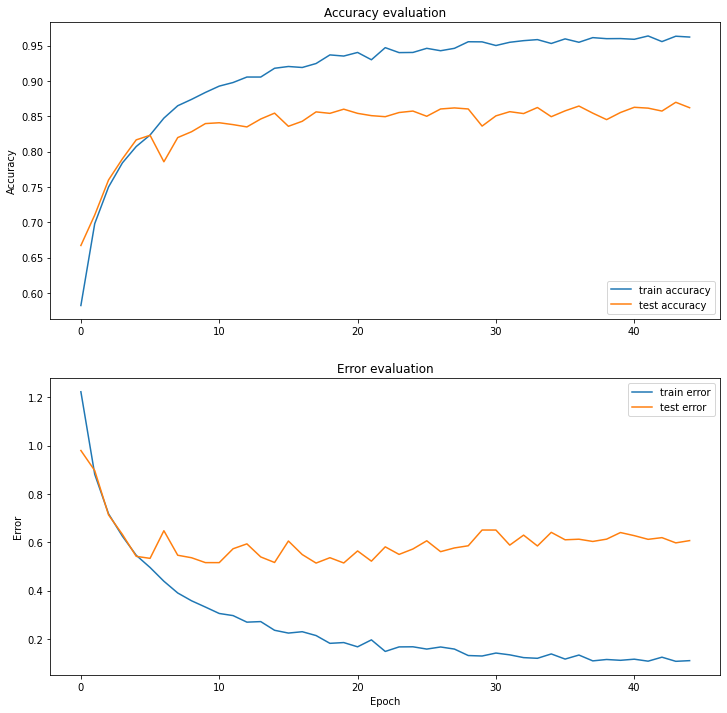

In [ ]:
fig, axs = plt.subplots(2, figsize=(12,12))

# create accuracy sublpot
axs[0].plot(history.history["accuracy"], label="train accuracy")
axs[0].plot(history.history["val_accuracy"], label="test accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy evaluation")

# create error sublpot
axs[1].plot(history.history["loss"], label="train error")
axs[1].plot(history.history["val_loss"], label="test error")
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Error evaluation")

plt.show()

## Predict

In [ ]:
p1 = history.model.predict(X_train)
p2 = history.model.predict(X_test)
knn = KNeighborsClassifier(9)
v = knn.fit(p1,y_train)
knn_model = knn.predict(p2)
knn_score = knn.score(p1, y_train)  

In [ ]:
accuracy = np.sum([1 for j in range(knn_model.shape[0]) if knn_model[j] == y_test[j]]) / knn_model.shape[0] # sum(model==dev_labels) / model.shape[0]
accuracy

0.8654168061600268

In [ ]:
print(classification_report(y_test, knn_model))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       322
           1       0.91      0.88      0.90       289
           2       0.84      0.84      0.84       313
           3       0.96      0.94      0.95       329
           4       0.89      0.86      0.88       303
           5       0.83      0.81      0.82       283
           6       0.91      0.93      0.92       306
           7       0.79      0.80      0.80       292
           8       0.82      0.84      0.83       280
           9       0.84      0.86      0.85       270

    accuracy                           0.87      2987
   macro avg       0.86      0.86      0.86      2987
weighted avg       0.87      0.87      0.87      2987



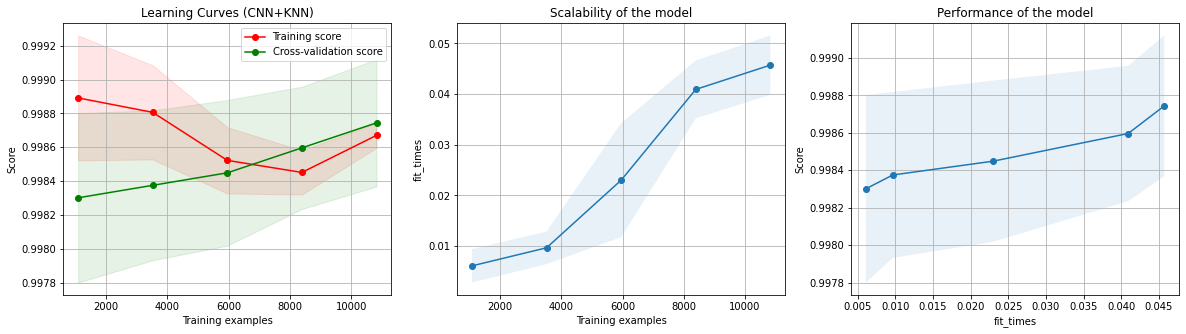

In [ ]:
title = "Learning Curves (CNN+KNN)"
cv = ShuffleSplit(n_splits=100, test_size=0.4, random_state=0)
plt = plot_learning_curve(knn, title, p1, y_train, n_jobs=4)

In [ ]:
cnn = lambda model, X: np.argmax(model.predict(X[np.newaxis, ...]), axis=1)

columns = ['Actual', 'CNN Predicted', 'CNN+KNN Predicted']
df = pd.DataFrame(columns = columns)
  
for i in range(20):
  ridx = random.randint(0, len(X_test))
  df.loc[i, 'Actual'] = genres[y_test[ridx]]
  df.loc[i, 'CNN Predicted'] = genres[cnn(model, X_test[ridx])[0]]
  df.loc[i, 'CNN+KNN Predicted'] = genres[knn_model[ridx]]
  
df

,Actual,CNN Predicted,CNN+KNN Predicted
0,trap,trap,trap
1,modern rock,pop,pop
2,pop rap,pop rap,pop rap
3,rap,rap,rap
4,rap,rap,rap
5,dance pop,dance pop,dance pop
6,trap latino,trap latino,trap latino
7,trap,trap,trap
8,pop rap,pop rap,pop rap
9,modern rock,modern rock,modern rock
